In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_3413534/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### results to reproduce:

#### LINCS
cellprofiler = 6.57458886

cellpainting_cnn = 7.480068624

dino = 7.95707877

#### PUMA

PUMA_CellProfiler = 25.19895355

PUMA_CPCNN = 27.22088501

PUMA_DINOsmall = 27.8769965

scaffold_median_python_dino

In [5]:
import os
os.chdir('../')
import torch
import pandas as pd
import numpy as np
import yaml
from sklearn import decomposition
from harmony import harmonize
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import cm
from tqdm import tqdm
import utils.label_dict
from utils.label_dict import protein_to_num_single_cells
from utils.analysis_utils import plot_UMAP, get_embeddings, create_cell_comparison, create_protein_hierarchy, get_gene_heterogeneity_enrichement, plot_gene_heterogeneity_enrichement, get_heterogeneity_df, scale, get_heterogeneousity_per_whole_image, get_col_matrix
from scipy.spatial.distance import pdist, cdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from seaborn import clustermap
from skimage import io
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scanpy as sc
from scipy.sparse.linalg import eigs
from scipy.stats import ttest_ind, zscore, norm
import seaborn as sb
cmap = cm.nipy_spectral


In [3]:

def get_averaged_features(df, features, labels, sort=True):
    mat, columns = get_col_matrix(df, labels)
    averaged_features = []
    for key in range(len(columns)):
        indices = np.where((mat[:,key] == 1) & (mat.sum(axis=1) == 1))
        averaged_features.append(features[indices].mean(axis=0))
    averaged_features = torch.stack(averaged_features)
    return averaged_features, columns



### Plot classification results

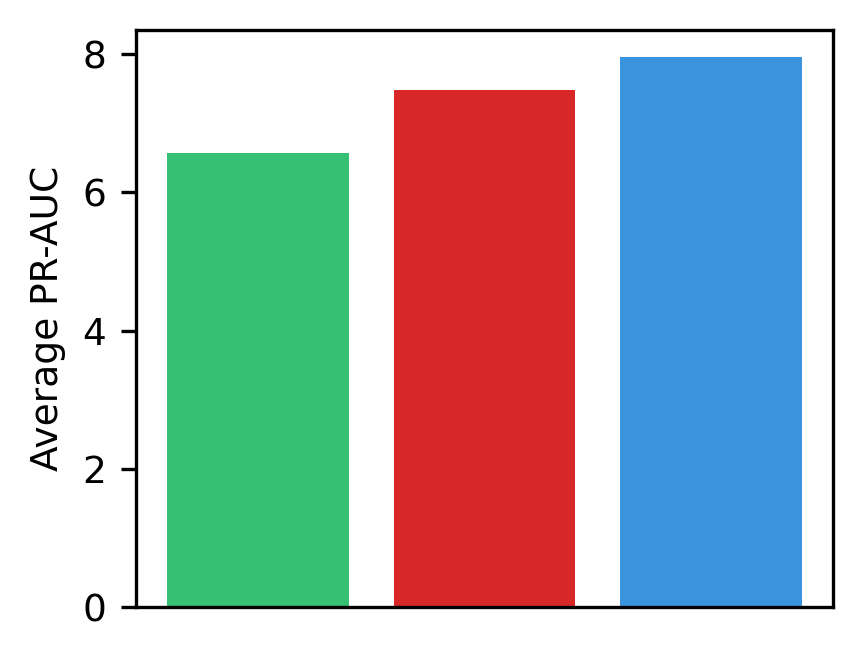

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
font = {'size'   : 9}
matplotlib.rc('font', **font)
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch
fig, axis = plt.subplots(1,1,figsize=(3,2.5), dpi=300)

cellprofiler = 6.57458886
cellpainting_cnn = 7.480068624
dino = 7.95707877

plt.bar(x=[0], height=[cellprofiler], color='#35c073')
plt.bar(x=[1], height=[cellpainting_cnn], color='#d72827')
plt.bar(x=[2], height=[dino], color='#3993dd')
plt.ylabel('Average PR-AUC')
plt.xticks([])
# plt.axis([-0.5, 2.5, 0, 1])
plt.savefig('results/Cell_Painting/Cell_Painting_LINCS.pdf', format='pdf')

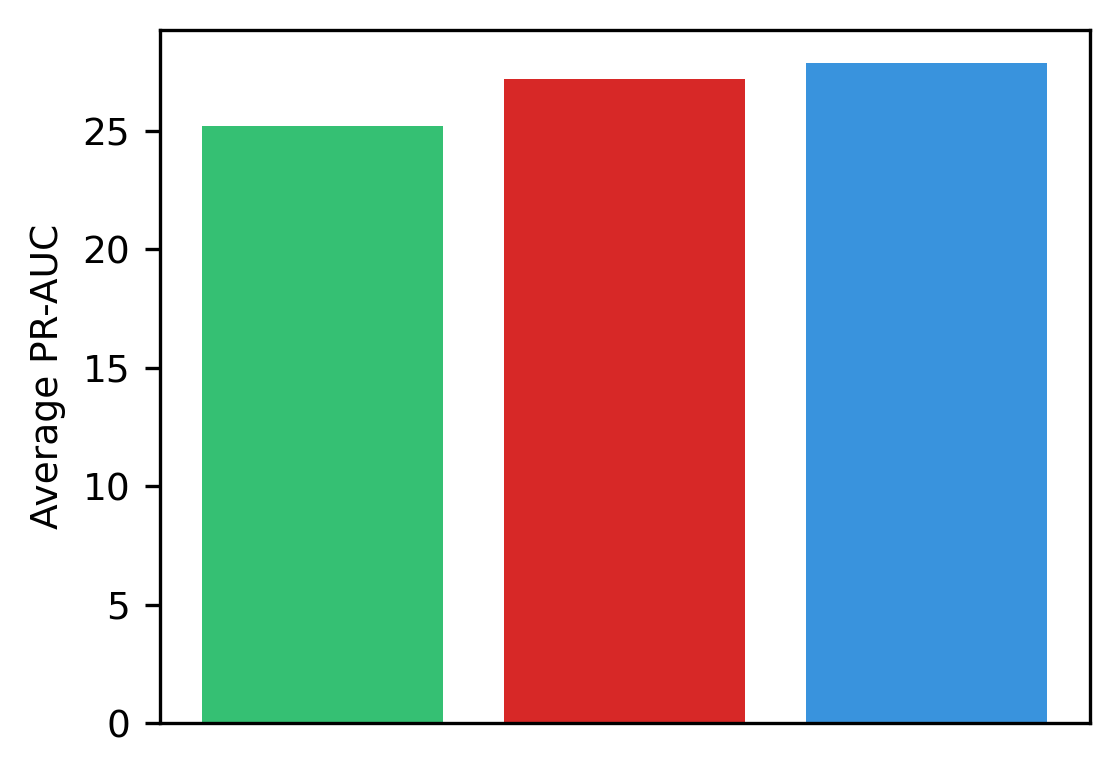

In [5]:
PUMA_CellProfiler = 25.19895355
PUMA_CPCNN = 27.22088501
PUMA_DINOsmall = 27.8769965
fig, axis = plt.subplots(1,1,figsize=(4,3), dpi=300)


plt.bar(x=[0], height=[PUMA_CellProfiler], color='#35c073')
plt.bar(x=[1], height=[PUMA_CPCNN], color='#d72827')
plt.bar(x=[2], height=[PUMA_DINOsmall], color='#3993dd')
plt.ylabel('Average PR-AUC')
plt.xticks([])
# plt.axis([-0.5, 2.5, 0, 1])
plt.savefig('results/Cell_Painting/Cell_Painting_PUMA.pdf', format='pdf')

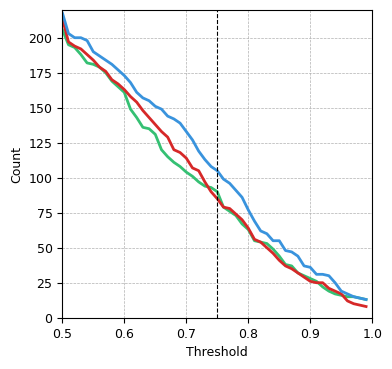

In [6]:
df = pd.read_csv("Cell_Painting_data/scaffold_median_python_dino.csv")

CS = df[df["descriptor"] == "mobc_es_op"]
MO = df[df["descriptor"] == "dinosmall1e2_es_op"]
GE = df[df["descriptor"] == "cnn1e2_es_op"]

counts = []
for t in np.arange(0.1, 1., 0.01):
    counts.append({"Threshold":t, "Count":np.sum(CS["auc"] > t), "Model":"CellProfiler"})
    counts.append({"Threshold":t, "Count":np.sum(GE["auc"] > t), "Model":"CP CNN"})
    counts.append({"Threshold":t, "Count":np.sum(MO["auc"] > t), "Model":"DINO"})

plt.gcf().set_size_inches(4, 4)    
counts = pd.DataFrame(data=counts)
ax = sb.lineplot(data=counts, x="Threshold", y="Count", hue="Model", 
             linewidth=2, palette=["#35C073", "#D62828", "#3993DD"])#, marker="o")
plt.plot([0.75,0.75],[0.0,270], "--k", linewidth=0.8)
plt.xlim([0.5,1.0])
plt.ylim([0,220])
plt.grid(linestyle="--", linewidth=0.5)
ax.get_legend().remove()
plt.savefig('results/Cell_Painting/Cell_Painting_PUMA_scaffold.pdf', format='pdf')

### Treatment similarity

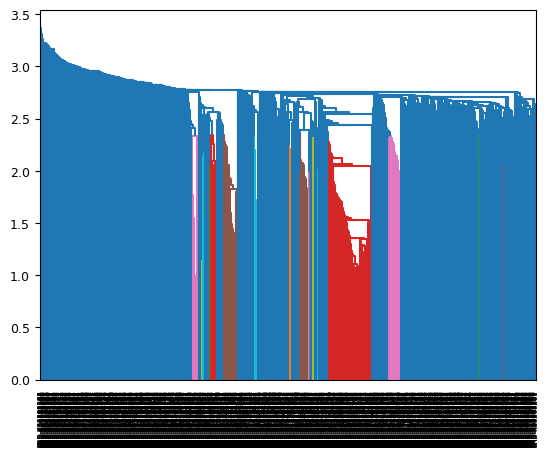

<Figure size 640x480 with 0 Axes>

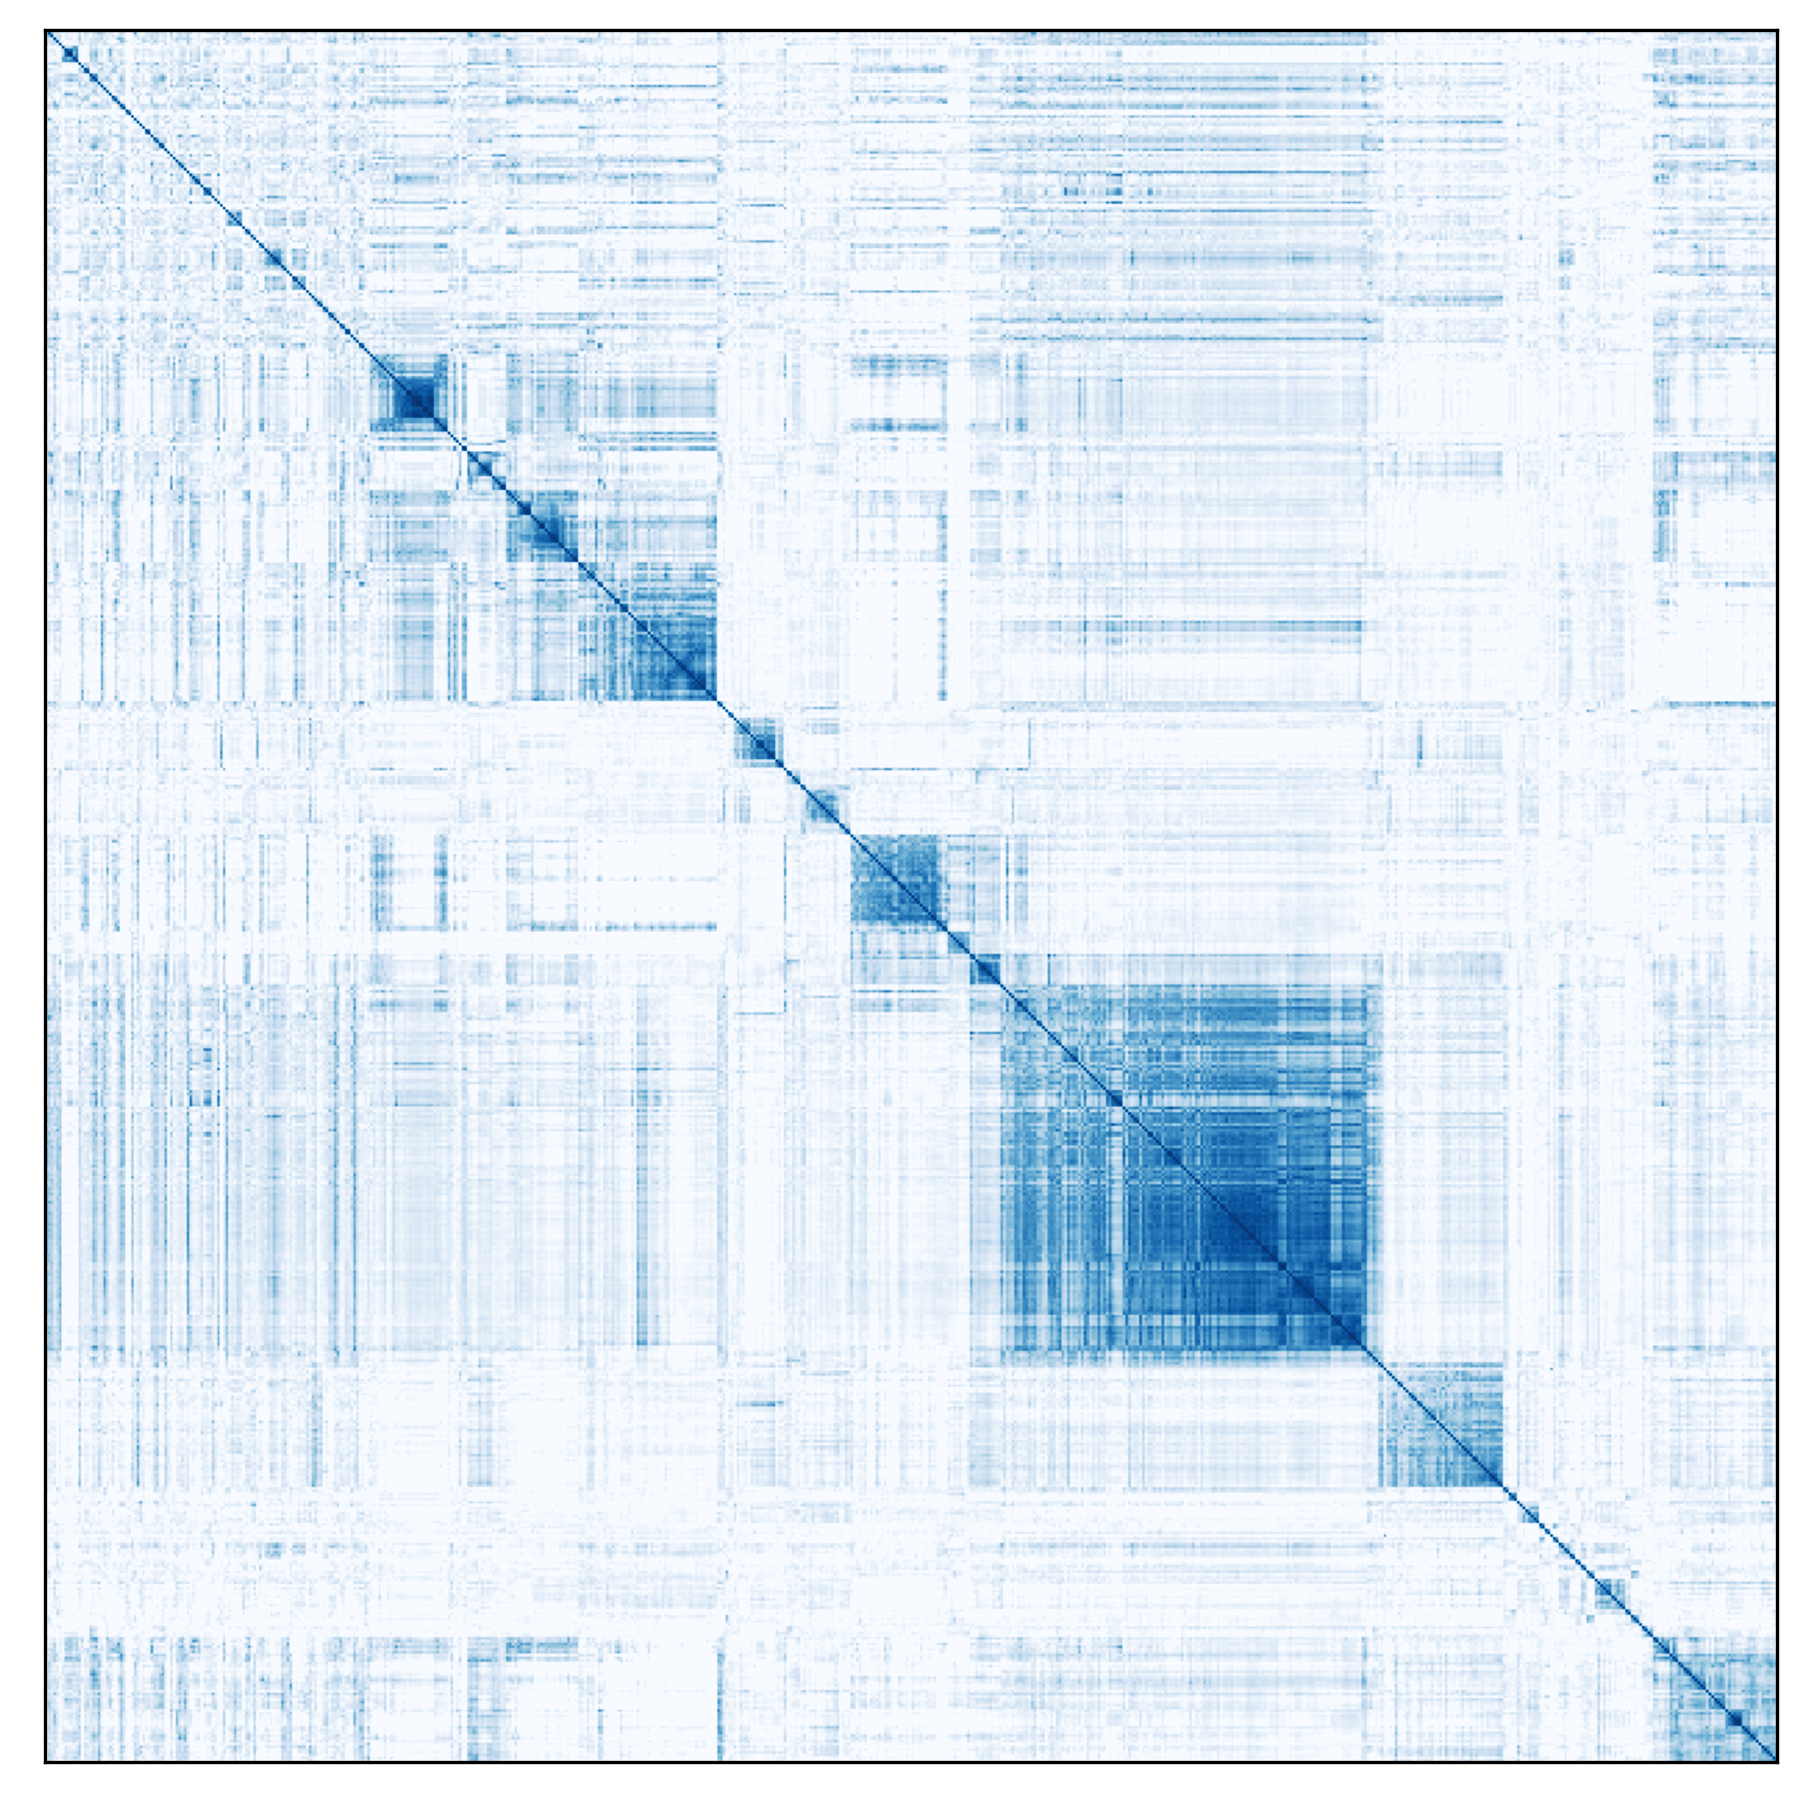

In [7]:
df_LINCS = pd.read_csv('Cell_Painting_data/UMAP_of_LINCS_ViT_Small_Compressed.csv')
features = df_LINCS[[f'{i}' for i in range(384)]].values

scaled_averaged_features, cell_columns = get_averaged_features(df_LINCS, torch.Tensor(features), ['Treatment_Clean'], sort=False)
reduced_averaged_features = 1 - squareform(pdist(scaled_averaged_features, metric='cosine'))

plt.figure()
ground_truth_Z = linkage(reduced_averaged_features, method='single')
dn = dendrogram(ground_truth_Z, labels = cell_columns)
reduced_averaged_features = reduced_averaged_features[dn['leaves'], :][:, dn['leaves']]
cell_columns = dn['ivl']

no_diag_reduced_averaged_features = np.copy(reduced_averaged_features)
for i in range(no_diag_reduced_averaged_features.shape[0]):
    no_diag_reduced_averaged_features[i,i] = 0
indices = sorted(np.argsort(no_diag_reduced_averaged_features.max(axis=0))[-int(len(no_diag_reduced_averaged_features.max(axis=0)) / 2) :])

plt.figure()
plt.figure(figsize=(7.5,7.5), dpi=300)
plt.imshow(reduced_averaged_features[:,indices][indices,:], cmap='Blues', vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
print('')
plt.savefig('results/Cell_Painting/Cell_Painting_treatment_similarity.pdf', format='pdf')

/tmp/ipykernel_787004/341325285.py:14: UserWarning: Glyph 128 (\x80) missing from current font.
  plt.savefig('results/Cell_Painting/Cell_Painting_similarity_MOA.pdf', format='pdf')
/tmp/ipykernel_787004/341325285.py:14: UserWarning: Glyph 147 (\x93) missing from current font.
  plt.savefig('results/Cell_Painting/Cell_Painting_similarity_MOA.pdf', format='pdf')
/tmp/ipykernel_787004/341325285.py:14: UserWarning: Glyph 128 (\x80) missing from current font.
  plt.savefig('results/Cell_Painting/Cell_Painting_similarity_MOA.pdf', format='pdf')
/tmp/ipykernel_787004/341325285.py:14: UserWarning: Glyph 147 (\x93) missing from current font.
  plt.savefig('results/Cell_Painting/Cell_Painting_similarity_MOA.pdf', format='pdf')


<Figure size 640x480 with 0 Axes>

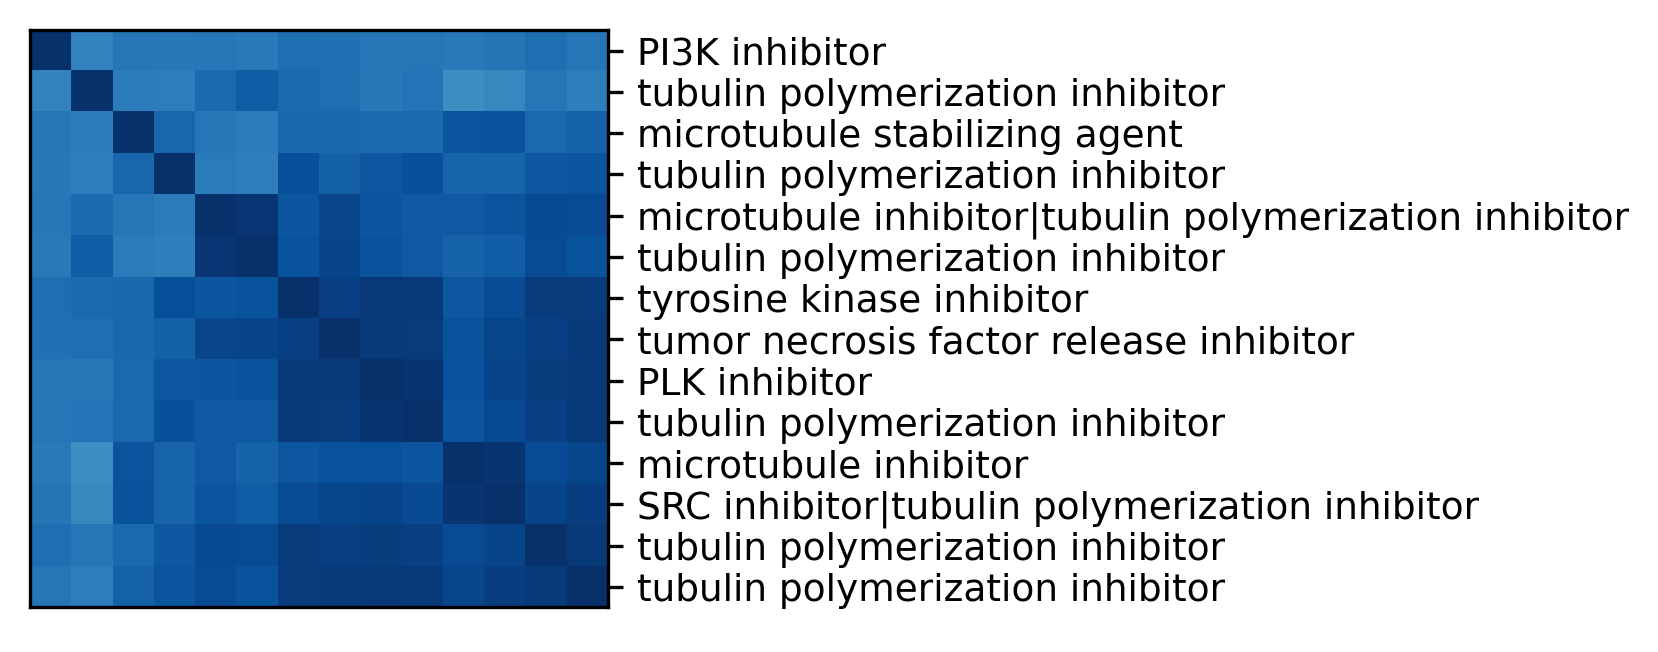

<Figure size 640x480 with 0 Axes>

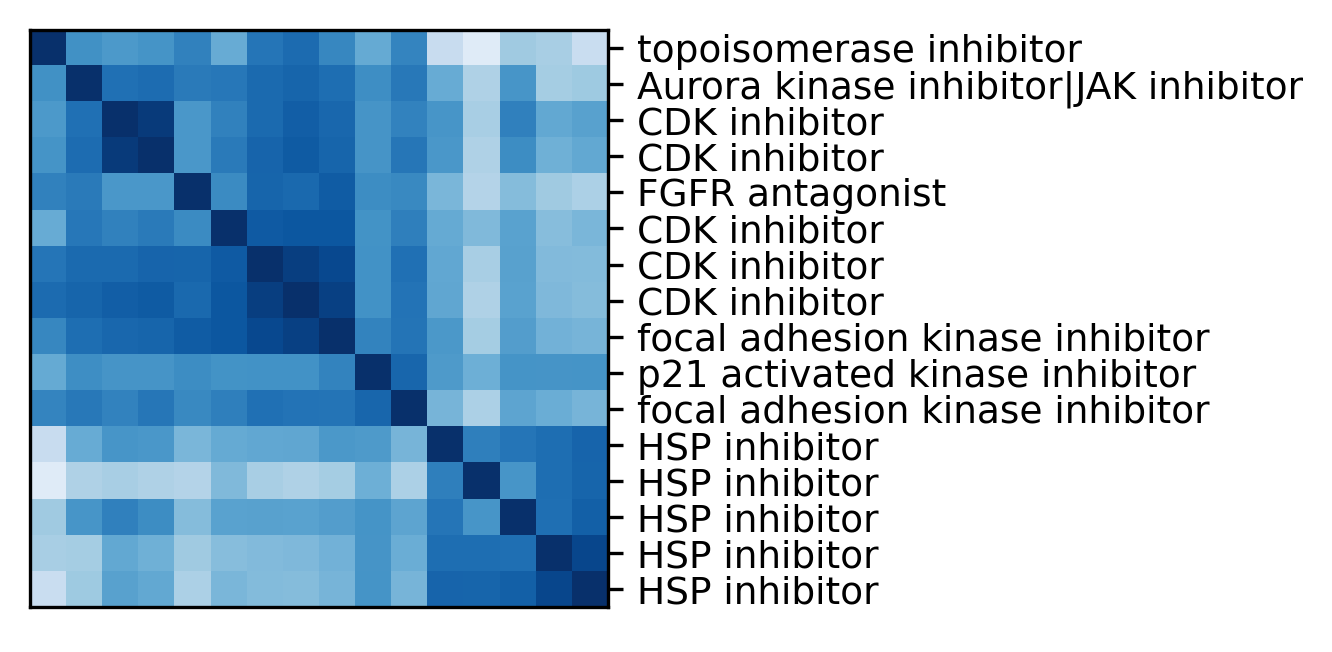

<Figure size 640x480 with 0 Axes>

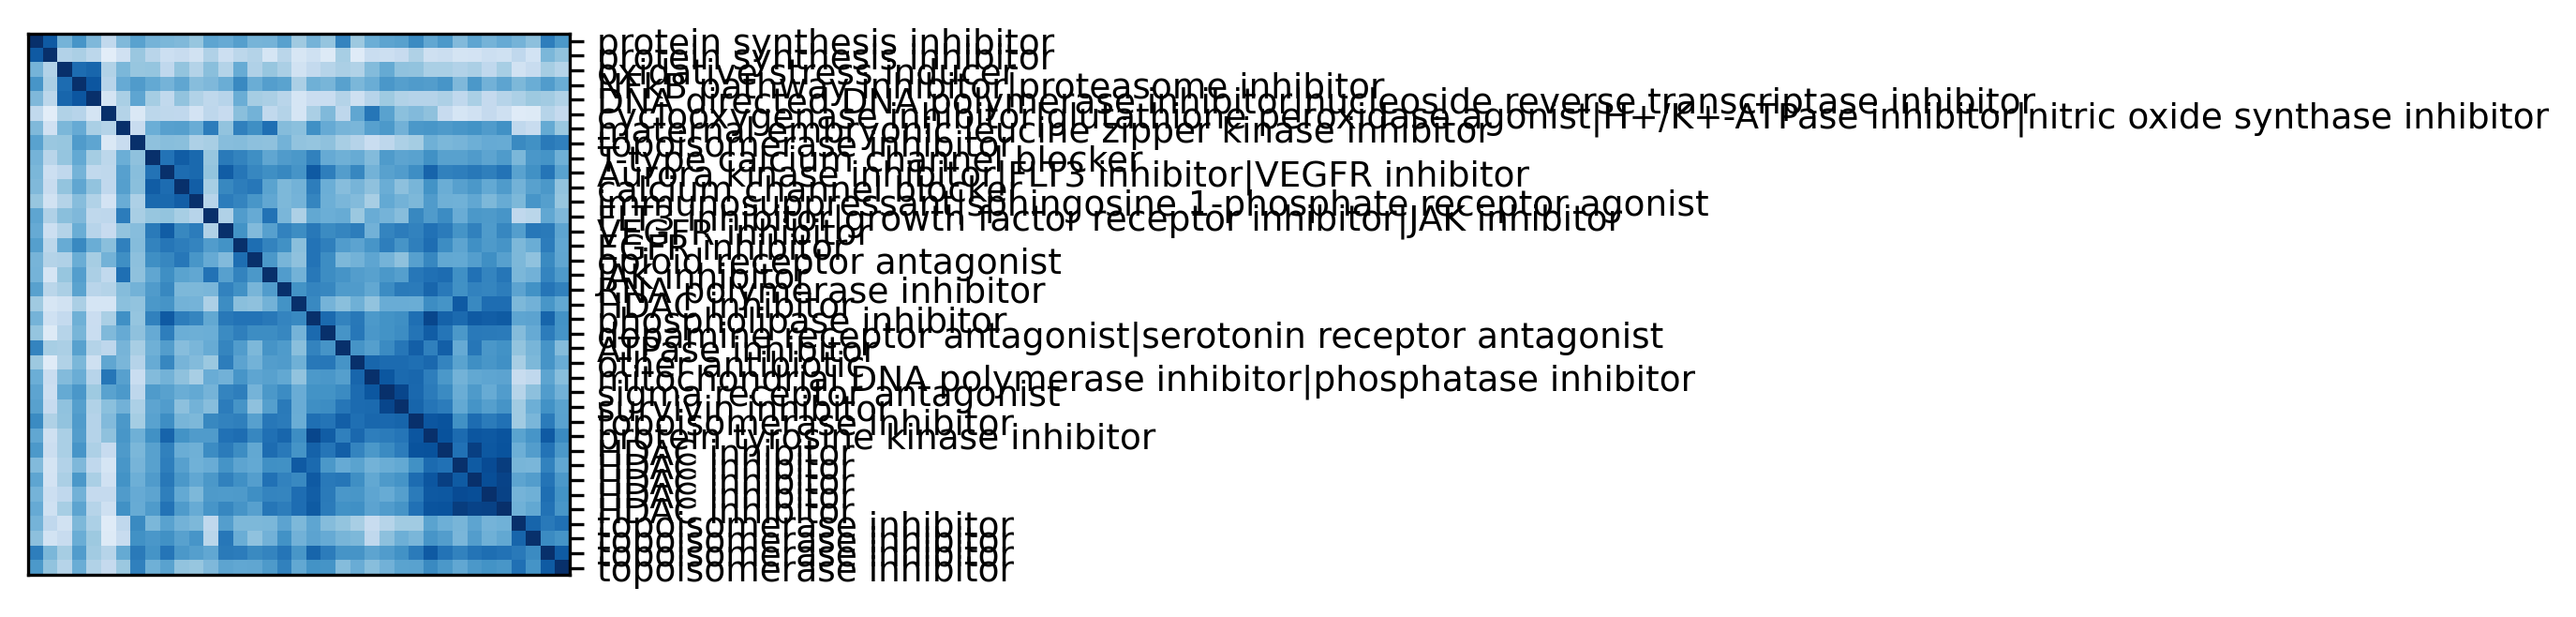

<Figure size 640x480 with 0 Axes>

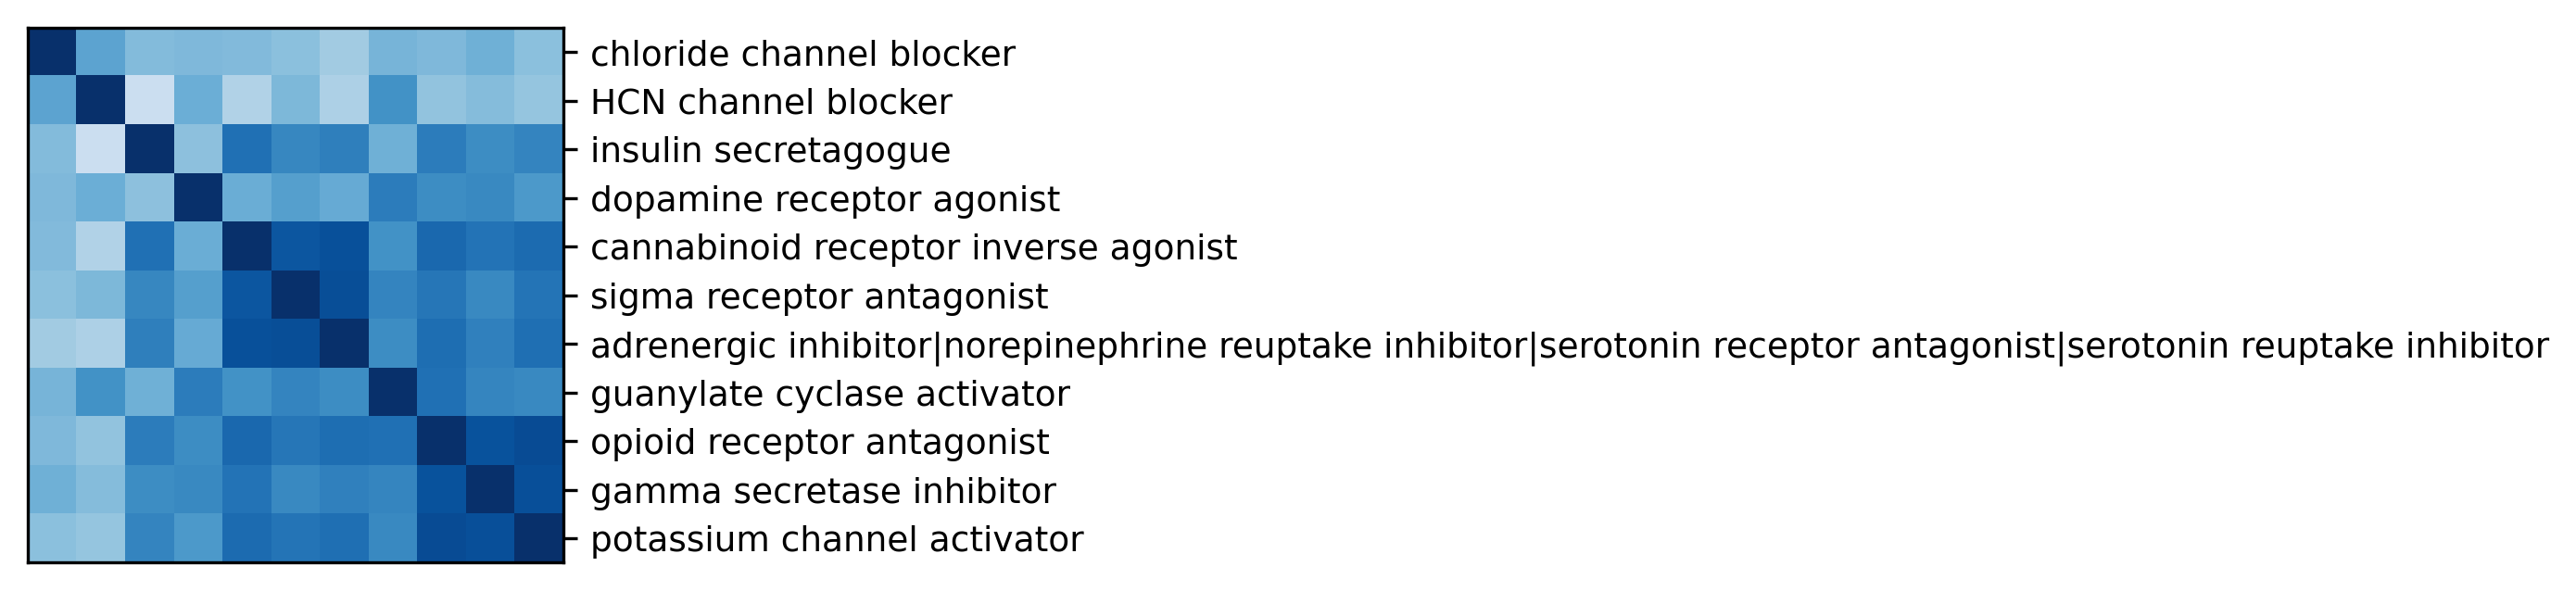

<Figure size 640x480 with 0 Axes>

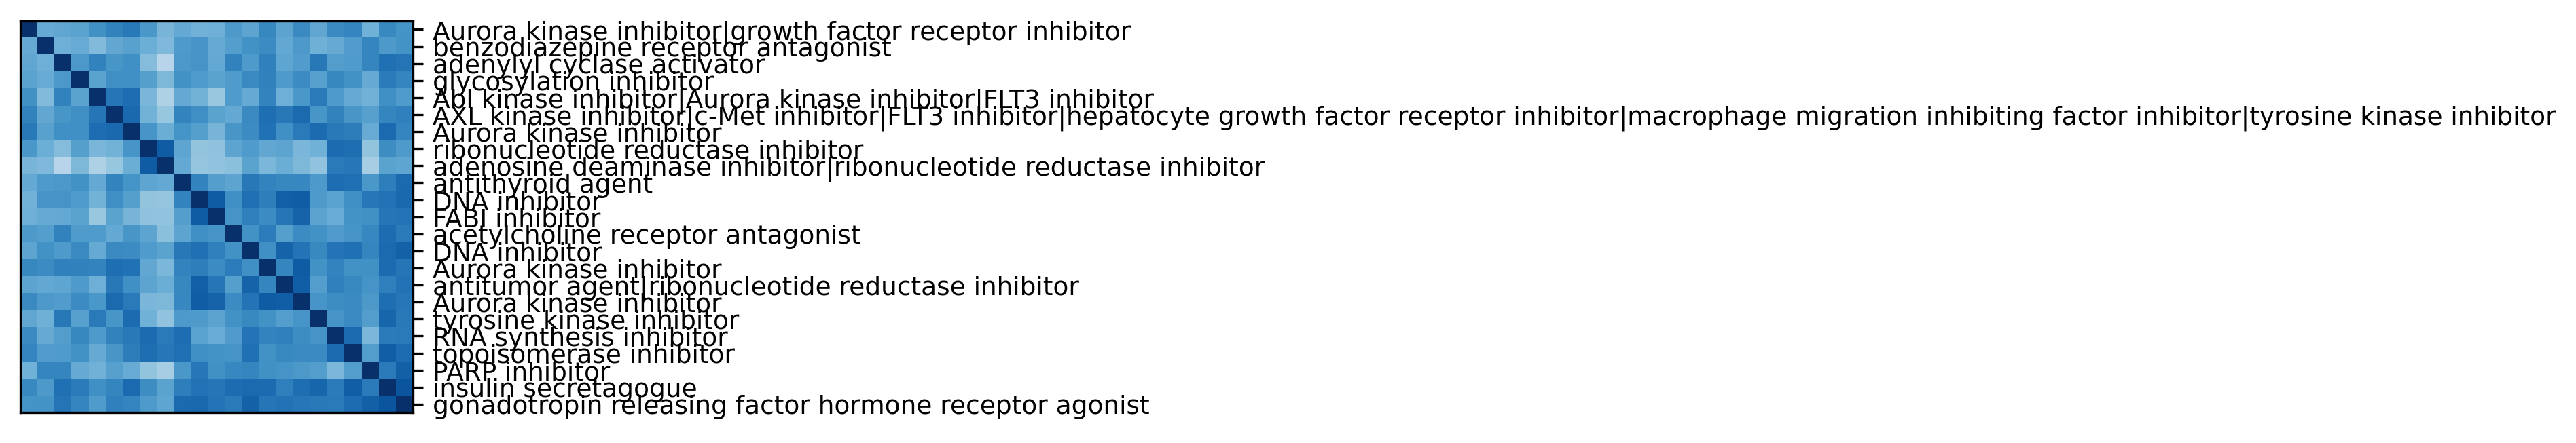

<Figure size 640x480 with 0 Axes>

/scr/mdoron/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/scr/mdoron/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


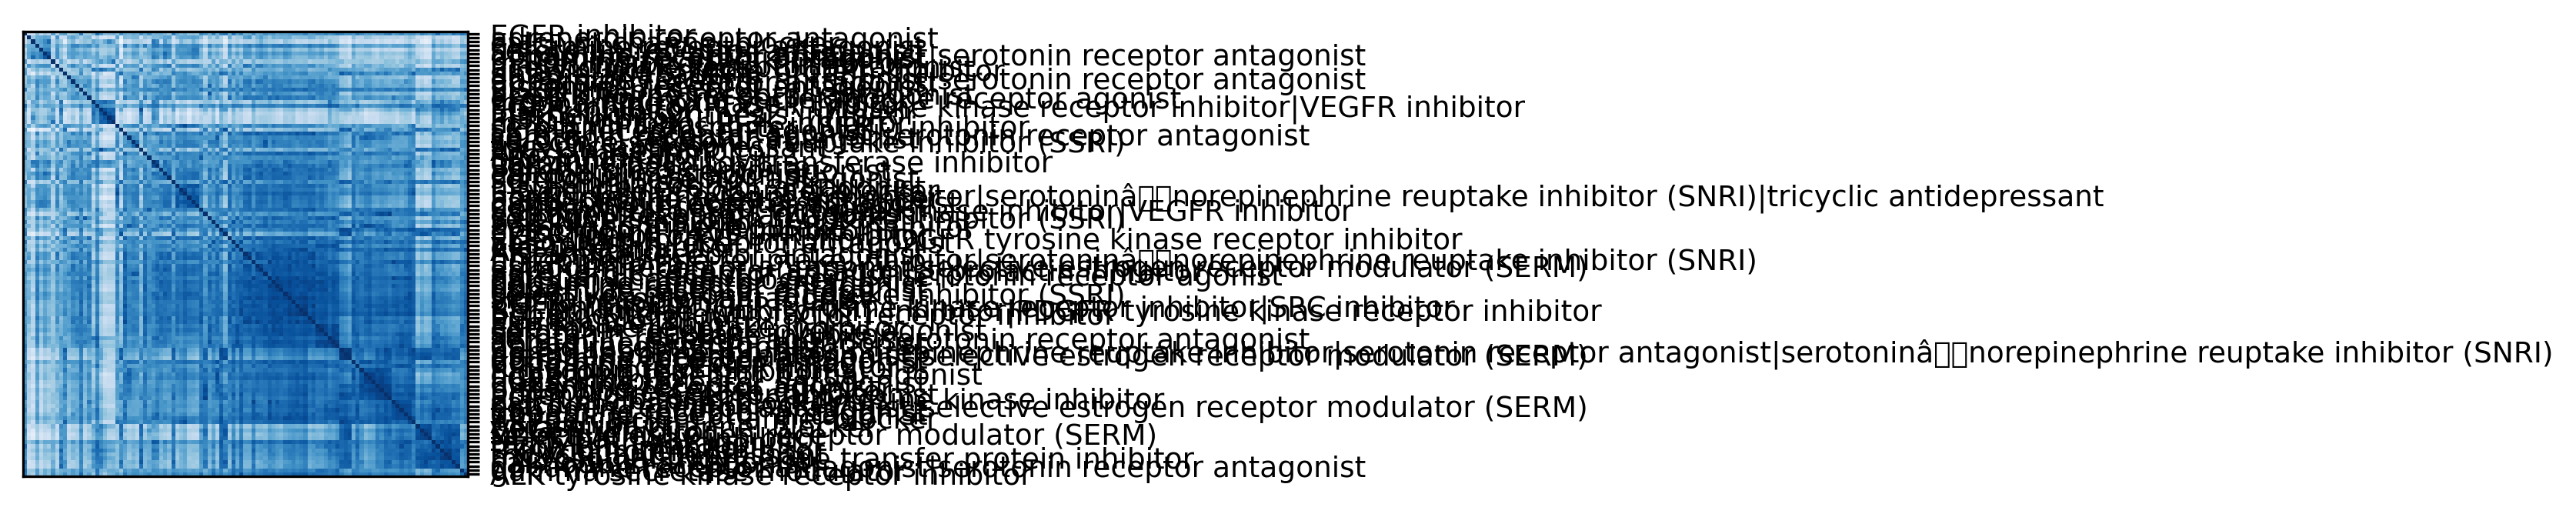

<Figure size 640x480 with 0 Axes>

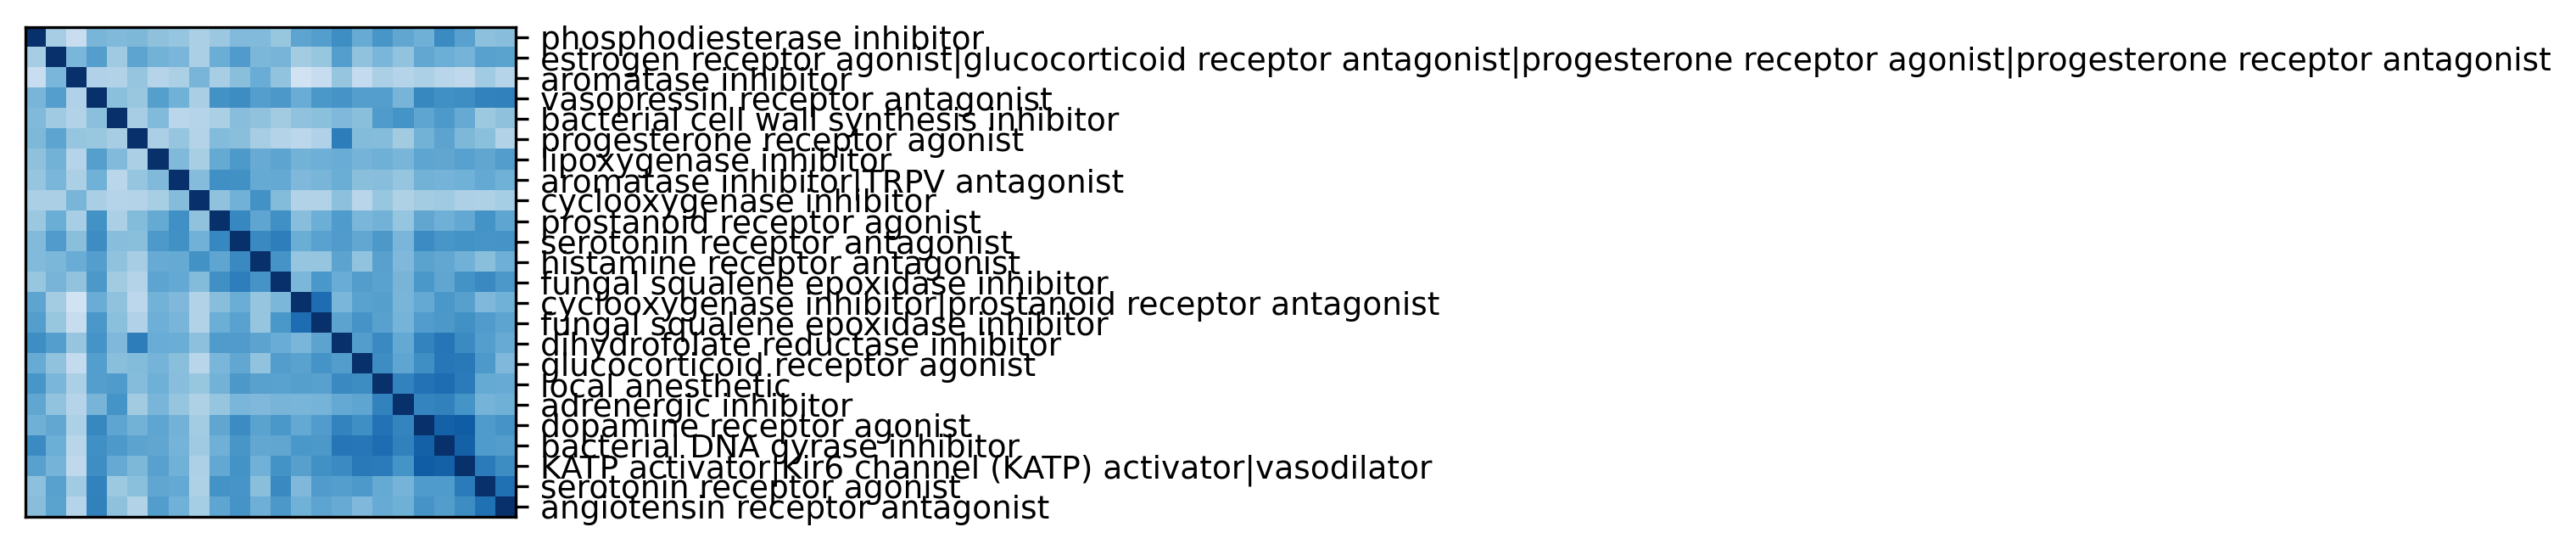

In [8]:
cluster_indices = fcluster(ground_truth_Z, t=2.3, criterion='distance')
cluster_indices = cluster_indices[dn['leaves']]
big_clusters = np.where([len(np.where(cluster_indices == i)[0]) > 10 for i in range(cluster_indices.max())])[0]
for cluster_ind in big_clusters:
    indices = np.where(cluster_indices == cluster_ind)[0]
    plt.figure()
    fig, ax = plt.subplots(1,1,figsize=(2.5,2.5), dpi=300)
    plt.imshow(reduced_averaged_features[indices,:][:,indices], cmap='Blues', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks(range(len(indices)), [df_LINCS[df_LINCS.Treatment_Clean == c].moa.iloc[0] for c in np.array(cell_columns)[indices]])
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    plt.savefig('results/Cell_Painting/Cell_Painting_similarity_MOA.pdf', format='pdf')

### Analysing key descriptors

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.32it/s]
/tmp/ipykernel_787004/3807515311.py:220: RuntimeWarning: invalid value encountered in double_scalars
  ratios.append(nucleus_IOU / cytosol_IOU)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


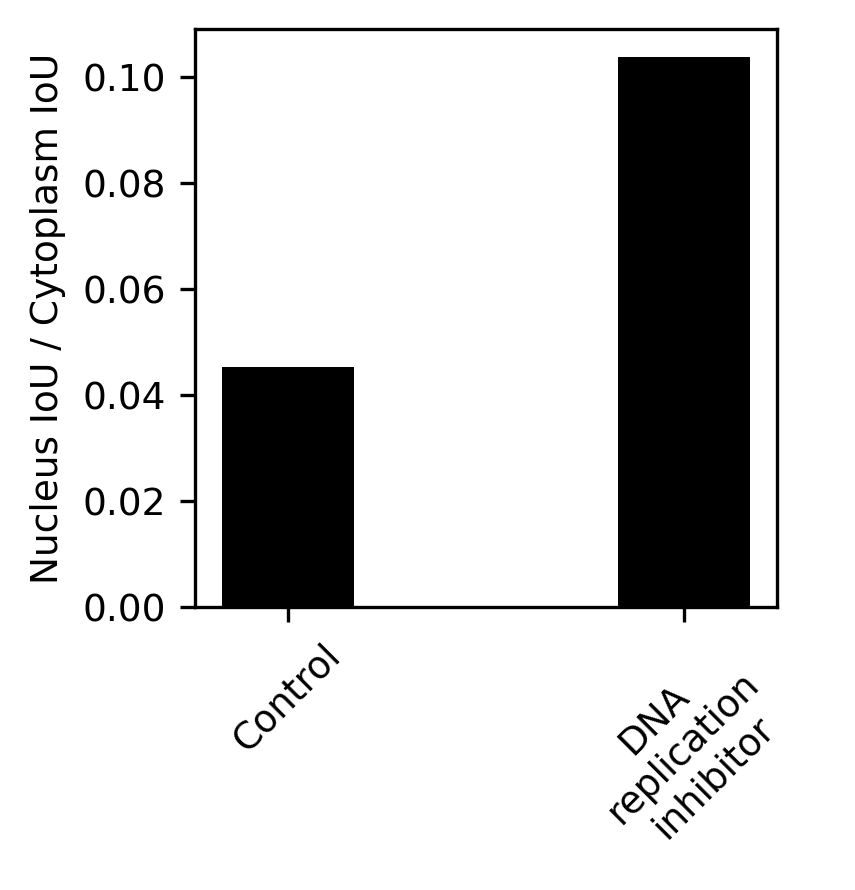

In [9]:
from sklearn.decomposition import PCA
import cv2
from matplotlib.colors import LinearSegmentedColormap
from skimage import io
from typing import Union, List, Tuple
from PIL import Image
from pathlib import Path
from torchvision import transforms
from utils.augmentations import Single_cell_Resize, Single_cell_centered, self_normalize
import utils.vision_transformer as vits
from utils.extractor import ViTExtractor
from skimage.filters import threshold_otsu
from scipy.spatial.distance import pdist, cdist
import faiss

class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict_group(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        incorrect_indices = np.where(np.ptp(votes, axis=1) > 0)
        zero_indices = np.where(votes[:,0] == 0)[0]
        one_indices = np.where(votes[:,0] == 1)[0]
        result = np.zeros(len(votes))
        result[one_indices] = 1
        result[zero_indices] = 0
        result[incorrect_indices] = np.nan
        return result
    
    def predict_cell(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        correct_cell = np.max(((votes[:, 1:] - votes[:,[0]]) == 0) == True, axis=1)
        return correct_cell

def preprocess(
    image_path: Union[str, Path],
    load_size: Union[int, Tuple[int, int]] = None,
) -> Tuple[torch.Tensor, Image.Image]:
    img = io.imread(image_path).transpose(1,2,0).astype(float)
    img = (img * 255).astype(np.uint8)
    pil_image = img
    if load_size is not None:
        pil_image = transforms.Resize(
            load_size, interpolation=transforms.InterpolationMode.LANCZOS
        )(pil_image.astype(float))
    prep = transforms.Compose(
        [
            transforms.ToTensor(),
            self_normalize(),
        ]
    )
    prep_img = prep(pil_image[:,:,[1,2,3]])[None, ...]
    return prep_img, pil_image


def fold_channels(image, training=True, mode="ignore"):
    output = np.reshape(image, (image.shape[0], image.shape[0], -1), order="F")

    if mode == "ignore":
        pass
    elif mode == "drop":
        output = output[:, :, 0:-1]
    elif mode == "apply":
        mask = sample["image"][:, :, -1:]
        output = output[:, :, 0:-1] * mask

    if training:
        return output
    else:
        h,w,c = output.shape
        hm = (h - 128)//2
        wm = (w - 128)//2
        o = output[hm:h-hm, wm:w-wm, :]
        return o
    
def cell_painting_preprocess(
    image_path: Union[str, Path],
    load_size: Union[int, Tuple[int, int]] = None,
) -> Tuple[torch.Tensor, Image.Image]:
    img = fold_channels(io.imread(image_path)).astype(float)[:,:,:5]
    img -= img.min(axis=(0,1))
    img /= img.max(axis=(0,1))
    img = (img * 255).astype(np.uint8)
    pil_image = img
    prep = transforms.Compose(
        [
            transforms.ToTensor(),
            Single_cell_Resize(),
#             Single_cell_centered(),
            self_normalize(),
        ]
    )
    prep_img = prep(pil_image)[None, ...]
    return prep_img, pil_image


model = vits.__dict__['vit_base'](
    img_size=[128],
    patch_size=16,
    drop_path_rate=0.1,  # stochastic depth
    in_chans=5,
)

state_dict = torch.load('Cell_Painting_data/DINO_cell_painting_model_checkpoint.pth')
teacher = state_dict
if "teacher" in state_dict.keys():
    teacher = state_dict["teacher"]
teacher = {k.replace("module.", ""): v for k, v in teacher.items()}
teacher = {k.replace("backbone.", ""): v for k, v in teacher.items()}
model.load_state_dict(teacher, strict=False)

extractor = ViTExtractor(
    model_type='dino_vits16',
    model=model,
    stride=4,
    device='cuda',
    load_size=224,
)

all_descriptors_clean = []
all_descriptors = []
all_images = []
all_features = []
num_cells_per_group = 50
for path in tqdm(list(Path('Cell_Painting_data/cell_painting_examples/control/').glob('*'))[:num_cells_per_group]):
    image_batch, image_pil = cell_painting_preprocess(path)
    masks = np.array([image_pil[:,:,i] > threshold_otsu(image_pil[:,:,i]) for i in range(5)])
    cell_mask = (np.sum(masks, axis=0).astype(bool).astype(int) - masks[0]).astype(bool)
    cell_mask = (cv2.resize(cell_mask.astype(float), dsize=(53, 53), interpolation=cv2.INTER_CUBIC) > 0.5)    
    descs = extractor.extract_descriptors(image_batch.to('cuda')).detach().cpu().numpy()[0,0,:,:]
    all_descriptors_clean.append(np.copy(descs))
    descs[cell_mask.flatten() == False,:] = 0
    all_descriptors.append(descs)
    all_images.append(np.array(image_pil))
    all_features.append(model(image_batch.to('cuda')).detach().cpu().numpy())

for path in tqdm(list(Path('Cell_Painting_data/cell_painting_examples/treated/').glob('*'))[:num_cells_per_group]):
    image_batch, image_pil = cell_painting_preprocess(path)
    masks = np.array([image_pil[:,:,i] > threshold_otsu(image_pil[:,:,i]) for i in range(5)])
    cell_mask = (np.sum(masks, axis=0).astype(bool).astype(int) - masks[0]).astype(bool)
    cell_mask = (cv2.resize(cell_mask.astype(float), dsize=(53, 53), interpolation=cv2.INTER_CUBIC) > 0.5)    
    descs = extractor.extract_descriptors(image_batch.to('cuda')).detach().cpu().numpy()[0,0,:,:]
    all_descriptors_clean.append(np.copy(descs))
    descs[cell_mask.flatten() == False,:] = 0
    all_descriptors.append(descs)
    all_images.append(np.array(image_pil))
    all_features.append(model(image_batch.to('cuda')).detach().cpu().numpy())

all_descriptors = np.stack(all_descriptors)
all_descriptors_clean = np.stack(all_descriptors_clean)
all_images = np.stack(all_images)

group_IDs = np.array([[0] * all_descriptors.shape[1] for i in range(num_cells_per_group)] + [[1] * all_descriptors.shape[1] for i in range(num_cells_per_group)]).flatten()
cell_IDs = np.array([[[j] * all_descriptors.shape[1]] for j in range(num_cells_per_group * 2)]).flatten()
n_components = 10
pca = PCA(n_components=n_components, whiten=True)
pca_descs = pca.fit_transform(np.concatenate(all_descriptors))
pca_descs_clean = pca.fit_transform(np.concatenate(all_descriptors_clean))
individual_pca_descs = pca_descs.reshape(all_descriptors.shape[0], all_descriptors.shape[1], n_components)

group_fknn = FaissKNeighbors(k=5)
queries = pca_descs[:,:4]
group_fknn.fit(queries, group_IDs)
predictions = group_fknn.predict_group(queries)
robust_group_descriptor_indices_0 = np.where(predictions == 0)[0]
robust_group_descriptor_indices_1 = np.where(predictions == 1)[0]


cell_fknn = FaissKNeighbors(k=2)
cell_fknn.fit(queries, cell_IDs)
predictions = cell_fknn.predict_cell(queries)
robust_cell_descriptor_indices = np.where(predictions)[0]

robust_group_descriptor_indices_0 = np.array(list(set(robust_group_descriptor_indices_0).difference(robust_cell_descriptor_indices)))
robust_group_descriptor_indices_1 = np.array(list(set(robust_group_descriptor_indices_1).difference(robust_cell_descriptor_indices)))
robust_group_descriptor_indices_0 = robust_group_descriptor_indices_0[:len(robust_group_descriptor_indices_1)]
robust_group_descriptor_indices_1 = robust_group_descriptor_indices_1[:len(robust_group_descriptor_indices_0)]

group_1_inds = list(range(num_cells_per_group))
group_2_inds = list(range(len(individual_pca_descs) - num_cells_per_group,len(individual_pca_descs),1))
cytosol_IOUs = []
nucleus_IOUs = []
ratios = []
individual_pca_descs = pca_descs.reshape(all_descriptors.shape[0], all_descriptors.shape[1], n_components)
informative_descriptors = np.array([np.unravel_index(ind, all_descriptors.shape[:2]) for ind in sorted(robust_group_descriptor_indices_0) + sorted(robust_group_descriptor_indices_1)])

for image_ind in range(len(individual_pca_descs)):
    informative_inds = informative_descriptors[np.where(informative_descriptors[:,0] == image_ind)[0], 1]
    mask = np.zeros((53, 53))
    masked_indices = np.array([np.unravel_index(ind, mask.shape) for ind in sorted(informative_inds)])
    mask.flat[informative_inds] = 1
    mask = (cv2.resize(mask, dsize=(160, 160), interpolation=cv2.INTER_CUBIC) > 0.5)
    masks = np.array([all_images[image_ind][:,:,i] > threshold_otsu(all_images[image_ind][:,:,i]) for i in range(5)])
    dna_mask = masks[0]
    non_dna_mask = np.sum(masks[1:], axis=0).astype(bool).astype(int) - masks[0]
    
    image_pil = all_images[image_ind]
    nucleus = dna_mask
    cytosol = non_dna_mask
    mask = mask * np.sum(masks, axis=0).astype(bool)
    overlap = nucleus * mask # Logical AND
    union = nucleus + mask # Logical OR
    nucleus_IOU = overlap.sum()/float(union.sum())
    nucleus_IOUs.append(nucleus_IOU)
    
    overlap = cytosol * mask # Logical AND
    union = cytosol + mask # Logical OR
    cytosol_IOU = overlap.sum()/float(union.sum())
    cytosol_IOUs.append(cytosol_IOU)
    ratios.append(nucleus_IOU / cytosol_IOU)
group_1_cytosol_IOUs = np.array(cytosol_IOUs)[group_1_inds]
group_1_nucleus_IOUs = np.array(nucleus_IOUs)[group_1_inds]

group_2_cytosol_IOUs = np.array(cytosol_IOUs)[group_2_inds]
group_2_nucleus_IOUs = np.array(nucleus_IOUs)[group_2_inds]

group_1_ratios = np.array(ratios)[group_1_inds]
group_2_ratios = np.array(ratios)[group_2_inds]

import matplotlib.ticker as mtick

fig, ax = plt.subplots(1,1,figsize=(2.5,2.5), dpi=300)
plt.bar(x=[0.25], 
        bottom=0,
        height=[
            np.nanmean(group_1_ratios),    
        ],
        color='black',
       width=0.5)

plt.bar(x=[1.75], 
        bottom=0,
        height=[
            np.nanmean(group_2_ratios),    
        ],
        color='black',
       width=0.5)

plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xticks([0.25, 1.75], ['Control', 'DNA\nreplication\ninhibitor'], rotation=45)
plt.ylabel('Nucleus IoU / Cytoplasm IoU')
plt.savefig('results/Cell_Painting/Cell_Painting_attention_ratio.pdf', format='pdf')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.09255962976148095
0.02847988608045568


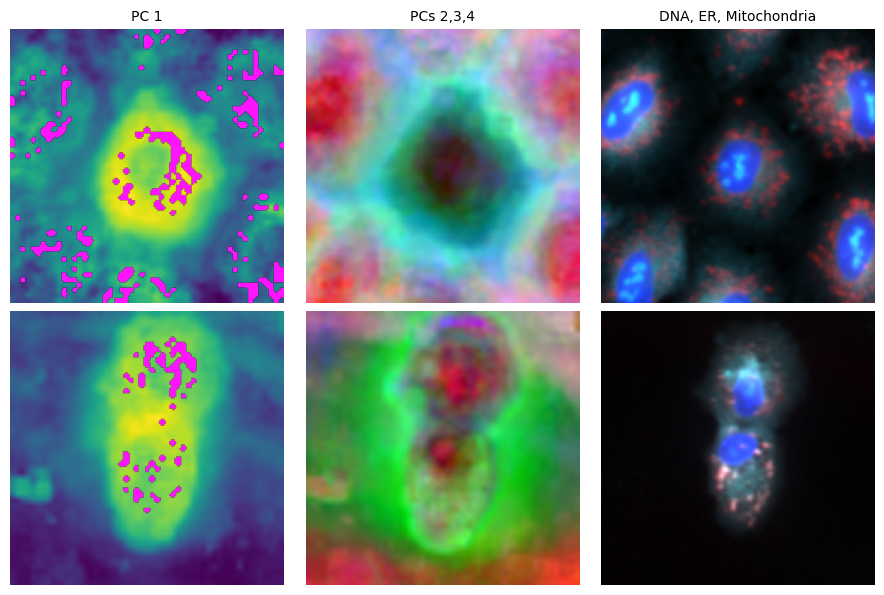

In [10]:
import cv2
from matplotlib.colors import LinearSegmentedColormap

magenta_cmap = LinearSegmentedColormap.from_list('magentas', ['#000000','#ff14ff'], N=256)
cyan_cmap = LinearSegmentedColormap.from_list('cyans', ['#000000','#00ffff'], N=256)
white_cmap = LinearSegmentedColormap.from_list('whites', ['#7a7a7a','#ffffff'], N=256)

individual_pca_descs_clean = pca_descs_clean.reshape(all_descriptors_clean.shape[0], all_descriptors.shape[1], n_components)
individual_pca_descs = pca_descs.reshape(all_descriptors.shape[0], all_descriptors.shape[1], n_components)
informative_descriptors = np.array([np.unravel_index(ind, all_descriptors_clean.shape[:2]) for ind in sorted(robust_group_descriptor_indices_0) + sorted(robust_group_descriptor_indices_1)])
row_size = 53
col_size = 53
size = 3
inds = [0, len(individual_pca_descs) - 14]
inds = [3, 51]
fig, axes = plt.subplots(len(inds),3,figsize=(3 * size, len(inds) * size * 160 / 160))

for axis_ind, (ind, desc, desc_clean) in enumerate(zip(inds, individual_pca_descs[inds], individual_pca_descs_clean[inds])):
    informative_inds = informative_descriptors[np.where(informative_descriptors[:,0] == ind)[0], 1]
    mask = np.zeros((row_size, col_size))
    masked_indices = np.array([np.unravel_index(ind, mask.shape) for ind in sorted(informative_inds)])
    mask.flat[informative_inds] = 1
    print(mask.mean())
    
    desc.reshape(row_size, col_size, desc.shape[-1]).shape
    desc = np.stack([cv2.resize(desc[:,c].reshape(row_size, col_size), dsize=(160, 160), interpolation=cv2.INTER_CUBIC) for c in range(n_components)]).transpose(1,2,0)
    desc_clean.reshape(row_size, col_size, desc_clean.shape[-1]).shape
    desc_clean = np.stack([cv2.resize(desc_clean[:,c].reshape(row_size, col_size), dsize=(160, 160), interpolation=cv2.INTER_CUBIC) for c in range(n_components)]).transpose(1,2,0)
    mask = (cv2.resize(mask, dsize=(160, 160), interpolation=cv2.INTER_CUBIC) > 0.5)
    
    masks = []
    for img_c in range(3):
        masks.append((all_images[ind, :, :, img_c] > 
                       threshold_otsu(all_images[ind, :, :, img_c].flatten()[all_images[ind, :, :, img_c].flatten().nonzero()])).astype(int))
    
    new_desc = np.copy(desc)
    new_desc -= new_desc.min(axis=(0,1))
    new_desc /= new_desc.max(axis=(0,1))
    
    new_desc_clean = np.copy(desc_clean)
    new_desc_clean -= new_desc_clean.min(axis=(0,1))
    new_desc_clean /= new_desc_clean.max(axis=(0,1))

    axes[axis_ind][0].imshow(new_desc_clean[:,:,0])
    axes[axis_ind][0].imshow(mask, alpha=mask.astype(float), cmap=magenta_cmap)
    axes[axis_ind][0].axis('off')
    
    axes[axis_ind][1].imshow(new_desc_clean[:,:,[1,2,3]])
    axes[axis_ind][1].axis('off')    
    
    im = np.copy(all_images[ind])
    nucleus = im[:,:,0]
    ER = im[:,:,1]
    mito = im[:,:,4]

    RGB = np.zeros((nucleus.shape[0], nucleus.shape[1], 3))

    RGB += nucleus[:,:,np.newaxis] * np.asarray([[[0,0,1]]])
    RGB += ER[:,:,np.newaxis] * np.asarray([[[0,1,1]]])
    RGB += mito[:,:,np.newaxis] * np.asarray([[[1,0,0]]])
    RGB = RGB / 255.    
    axes[axis_ind][2].imshow(RGB)
#     axes[axis_ind][2].imshow(mask, alpha=mask.astype(float), cmap=magenta_cmap)
    axes[axis_ind][2].axis('off')

channel_names = ['PC 1','PCs 2,3,4','DNA, ER, Mitochondria']
for c,name in enumerate(channel_names):
    axes[0][c].set_title(name, fontsize=10)
plt.tight_layout()
plt.savefig('results/Cell_Painting/Cell_Painting_attention_cells.pdf', format='pdf')


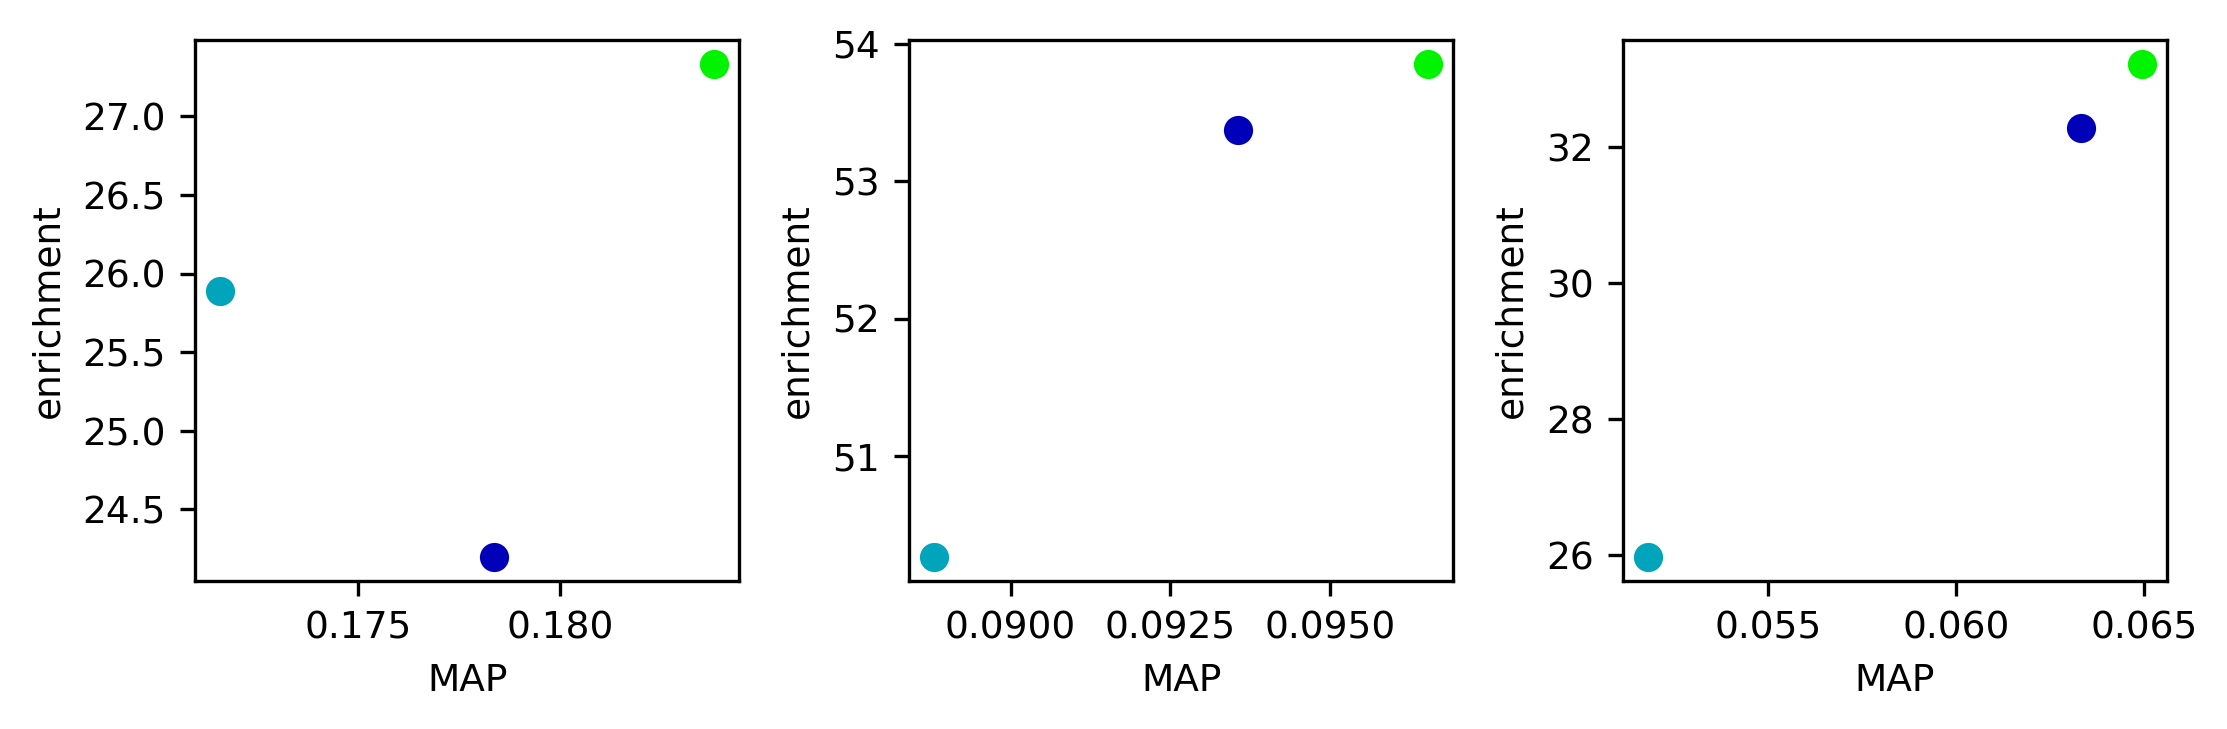

In [7]:
font = {'size'   : 9}
matplotlib.rc('font', **font)
cmap = cm.nipy_spectral

TAORF_ViT_Base_300_enrichment = 24.2
TAORF_ViT_Base_300_MAP = 0.1783741585
TAORF_CellProfiler_enrichment = 25.89
TAORF_CellProfiler_MAP = 0.1715952782
TAORF_ImageNet_enrichment = 23.27
TAORF_ImageNet_MAP = 0.164134703
TAORF_CNN_enrichment = 27.33
TAORF_CNN_MAP = 0.18382
TAORF_enrichment = 24.92
TAORF_MAP = 0.18033

BBBC022_ViT_Base_300_enrichment = 53.37
BBBC022_ViT_Base_300_MAP = 0.09356398887
BBBC022_CellProfiler_enrichment = 50.27
BBBC022_CellProfiler_MAP = 0.088801
BBBC022_ImageNet_enrichment = 49.97
BBBC022_ImageNet_MAP = 0.09023
BBBC022_CNN_enrichment = 53.85
BBBC022_CNN_MAP = 0.096541
BBBC022_enrichment = 44.68
BBBC022_MAP = 0.08996

CDRP_ViT_Base_300_enrichment = 32.29
CDRP_ViT_Base_300_MAP = 0.06333469423
CDRP_CellProfiler_enrichment = 25.98
CDRP_CellProfiler_MAP = 0.051813
CDRP_ImageNet_enrichment = 26.83
CDRP_ImageNet_MAP = 0.057885
CDRP_CNN_enrichment = 33.22
CDRP_CNN_MAP = 0.064951
CDRP_enrichment = 34.88
CDRP_MAP = 0.066742


fig, axes = plt.subplots(1, 3, figsize=(2.5 * 3,2.5), dpi=300)
axes[0].scatter(TAORF_ViT_Base_300_MAP, 
                TAORF_ViT_Base_300_enrichment, label='DINO', color=cmap(1 / 6))
axes[0].scatter(TAORF_CellProfiler_MAP, 
                TAORF_CellProfiler_enrichment, label='CellProfiler', color=cmap(2 / 6))
# axes[0].scatter(TAORF_ImageNet_MAP, 
#                 TAORF_ImageNet_enrichment, label='ImageNet', color=cmap(3 / 6))
axes[0].scatter(TAORF_CNN_MAP, 
                TAORF_CNN_enrichment, label='CNN', color=cmap(3.5 / 6))
# axes[0].scatter(TAORF_MAP, 
#                 TAORF_enrichment, label='TAORF', color=cmap(5 / 6))
axes[0].set_ylabel('enrichment')
axes[0].set_xlabel('MAP')
# axes[0].legend(frameon=False)

axes[1].scatter(BBBC022_ViT_Base_300_MAP, 
                BBBC022_ViT_Base_300_enrichment, label='DINO', color=cmap(1 / 6))
axes[1].scatter(BBBC022_CellProfiler_MAP, 
                BBBC022_CellProfiler_enrichment, label='CellProfiler', color=cmap(2 / 6))
# axes[1].scatter(BBBC022_ImageNet_MAP, 
#                 BBBC022_ImageNet_enrichment, label='ImageNet', color=cmap(3 / 6))
axes[1].scatter(BBBC022_CNN_MAP, 
                BBBC022_CNN_enrichment, label='CNN', color=cmap(3.5 / 6))
# axes[1].scatter(BBBC022_MAP, 
#                 BBBC022_enrichment, label='BBBC022', color=cmap(5 / 6))
axes[1].set_ylabel('enrichment')
axes[1].set_xlabel('MAP')
# axes[1].legend(frameon=False)

axes[2].scatter(CDRP_ViT_Base_300_MAP, 
                CDRP_ViT_Base_300_enrichment, label='DINO', color=cmap(1 / 6))
axes[2].scatter(CDRP_CellProfiler_MAP, 
                CDRP_CellProfiler_enrichment, label='CellProfiler', color=cmap(2 / 6))
# axes[2].scatter(CDRP_ImageNet_MAP, 
#                 CDRP_ImageNet_enrichment, label='ImageNet', color=cmap(3 / 6))
axes[2].scatter(CDRP_CNN_MAP, 
                CDRP_CNN_enrichment, label='CNN', color=cmap(3.5 / 6))
# axes[2].scatter(CDRP_MAP, 
#                 CDRP_enrichment, label='CDRP', color=cmap(5 / 6))
axes[2].set_ylabel('enrichment')
axes[2].set_xlabel('MAP')
# axes[2].legend(frameon=False)
plt.tight_layout()